In [1]:
from migdalcalc import migdalcalc
from migdalcalc.migdal import kinematics as kin
from migdalcalc.migdal import ionization as ion
import numpy as np
import scipy.integrate as integrate


%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100
plt.rcParams['text.usetex'] = False

In [2]:
A = 40
N_per_g = (6.02e23/A)
barns_to_cm2 = 1e-24
flux = 100 #nuetrons/cm^2/second
days_to_seconds = 60*60*24 #days to seconds

R = 5 #cm
L = 1 #cm

V = (np.pi*R**2)*L
density = 1.395 #g / cm^3

mass = 1000 #grams

rate_prefactor = N_per_g*mass*barns_to_cm2*flux*days_to_seconds


Argon Elastic Cross Section (barns): 2.08998


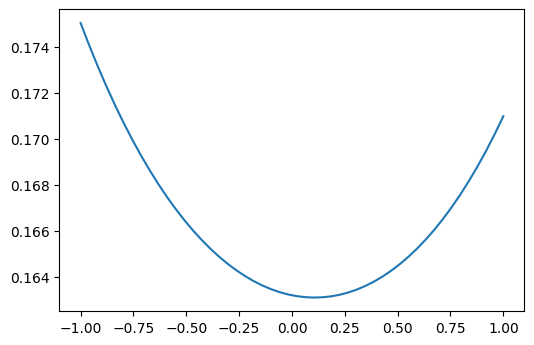

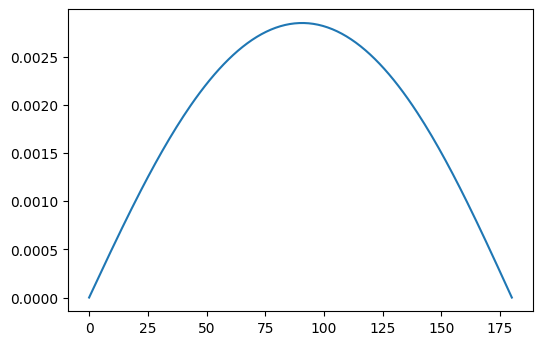

2.08998


In [3]:
En = 100*1e3
Ar_migdal = migdalcalc.migdalcalc(target="Ar-40")

Ar_elastic_xsec = Ar_migdal.nuc.SIG(En)
print("Argon Elastic Cross Section (barns): " + str(Ar_elastic_xsec))

Ar_dSigdOmega = Ar_migdal.nuc.dSig_dOmega(En)

c_range = np.linspace(-1, 1)
angle_range = np.linspace(0, 180, 180)


plt.plot(c_range, Ar_dSigdOmega(c_range))
plt.show()


plt.plot(angle_range, (np.pi/180)*np.sin(np.pi*angle_range/180)*Ar_dSigdOmega(np.cos(np.pi*angle_range/180)))
plt.show()

print(2*np.pi*integrate.quad(lambda t:(np.pi/180)*np.sin(np.pi*t/180)*Ar_dSigdOmega(np.cos(np.pi*t/180)), 0, 180)[0])



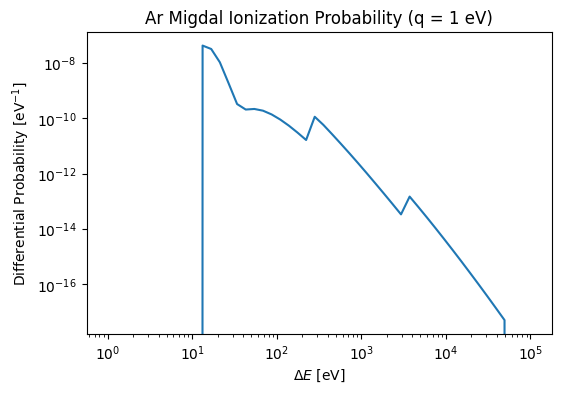

Migdal Estimated Cross Section (barns): 0.021490758647254343


In [4]:
dE_range = np.geomspace(1, 1e5)

plt.plot(dE_range, Ar_migdal.mig.dP_dDeltaE(dE_range))
plt.yscale('log')
plt.xscale('log')
plt.title("Ar Migdal Ionization Probability (q = 1 eV)")
plt.xlabel(r'$\Delta E$ [eV]')
plt.ylabel("Differential Probability [eV$^{-1}$]")
plt.show()

migdal_integrated_probability = integrate.quad(Ar_migdal.mig.dP_dDeltaE, 0, 1e5, epsrel=1e-3)
approximate_scalefactor = kin.q_e2(kin.E0(40, En), 40)
print("Migdal Estimated Cross Section (barns): " + str(Ar_elastic_xsec*approximate_scalefactor*migdal_integrated_probability[0]))

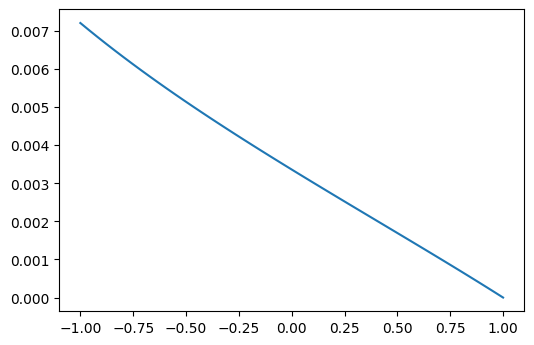

Migdal Cross Section (barns): 0.0068779094720552375


In [5]:
migdal_xsec_cos_dE = Ar_migdal.d2R_dc_dDeltaE(En)

c_range = np.linspace(-1, 1)

mig_xsec_cos = []
for c in c_range:
    mig_xsec_cos.append(integrate.quad(lambda dE: migdal_xsec_cos_dE(dE,c), 0, 1e5,limit=100,epsrel=1e-3)[0])
    
plt.plot(c_range, mig_xsec_cos)
plt.show()

migdal_xsec = integrate.trapz(mig_xsec_cos, c_range)
print("Migdal Cross Section (barns): " + str(migdal_xsec))


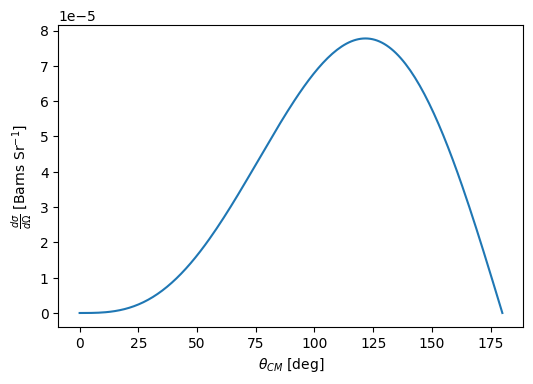

0.006877573231871947


In [6]:
angle_range = np.linspace(0, 180, 180)
mig_xsec_angle = []

for angle in angle_range:
    c = np.cos(np.pi*angle/180)
    mig_xsec_angle.append((np.pi/180)*np.sin(np.pi*angle/180)*integrate.quad(lambda dE: migdal_xsec_cos_dE(dE,c), 0, 1e5,limit=100,epsrel=1e-3)[0])
    
plt.plot(angle_range, mig_xsec_angle)
plt.xlabel(r'$\theta_{CM}$ [deg]')
plt.ylabel(r'$\frac{d \sigma}{d \Omega}$ [Barns Sr$^{-1}$]')
plt.show()

migdal_xsec = integrate.trapz(mig_xsec_angle, angle_range)
print(migdal_xsec)

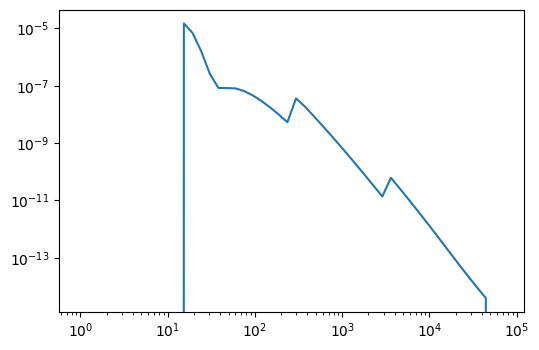

In [7]:
angle = 15 
c = np.cos(np.pi*angle/180)

dE_range = np.geomspace(1, 70e3)

plt.plot(dE_range, migdal_xsec_cos_dE(dE_range, c))
plt.xscale('log')
plt.yscale('log')

In [8]:
Ar_quench = lambda E: 0.25
migdal_ionization_spectrum = Ar_migdal.dR_dEion(c, En, Ar_quench)

binned_migdal_spectrum = ion.noblegas_electron_spectrum_binned(migdal_ionization_spectrum, Ar_quench, 19.5, 0.05,
                                                              En, c, 40, flux=1, number_of_bins=20, fano=False)

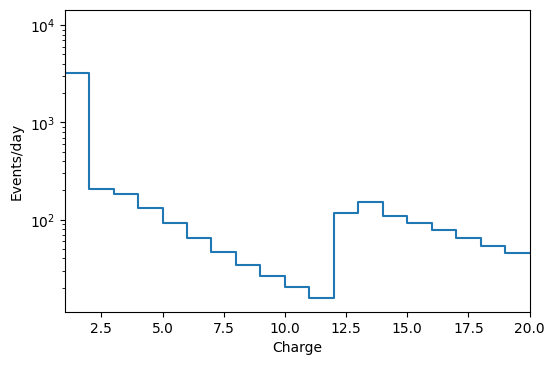

40.54036134554633


In [10]:
plt.step(binned_migdal_spectrum[0], np.multiply(rate_prefactor,binned_migdal_spectrum[1]))
plt.yscale('log')
plt.xlim(1, 20)
plt.xlabel("Charge")
plt.ylabel('Events/day')
plt.show()

print(2*(1-c)*kin.E0(40,En)*Ar_quench(0))